# Week 6: Performance contd. and Loss Functions

### Aims:
* To gain some practical experience in evaluating supervised machine learning
models.
* To produce some assessable work for this subject.

### Procedure:
In Example 4.5 in the Lindholm et al. textbook, a thyroid dataset is used. This dataset
is available on the course blackboard site (downloaded from:
https://archive.ics.uci.edu/ml/datasets/thyroid+disease), in the files `ann-
train.data` and `ann-test.data` (it seems the books has used these files for their
training and hold-out validation sets). The files are (space delimited) “csv” files, with
the last column being the class label.

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [5]:
# Common Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# ANSI color
class color:
  GREEN_BOLD = '\033[1;32m'
  YELLOW_BOLD = '\033[1;33m'
  BLUE_BOLD = '\033[1;34m'
  WHITE_BOLD = '\033[1;37m'
  END = '\033[0m'

### Q1: Train a k-NN model (choose some reasonable value for k) on the training set and calculate a confusion matrix for the hold-out validation set.

In [7]:
# Specific Imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from os import read      # Due to read_csv() problems
from io import StringIO  # Due to read_csv() problems

In [9]:
def read_data(filename):
  with open(filename, 'r') as f:
    content = f.read()
  lines = content.split("  ")
  return pd.read_csv(StringIO("\n".join(lines)), header=None, sep=" ")

df_train = read_data("ann-train.data")
df_test = read_data("ann-test.data")

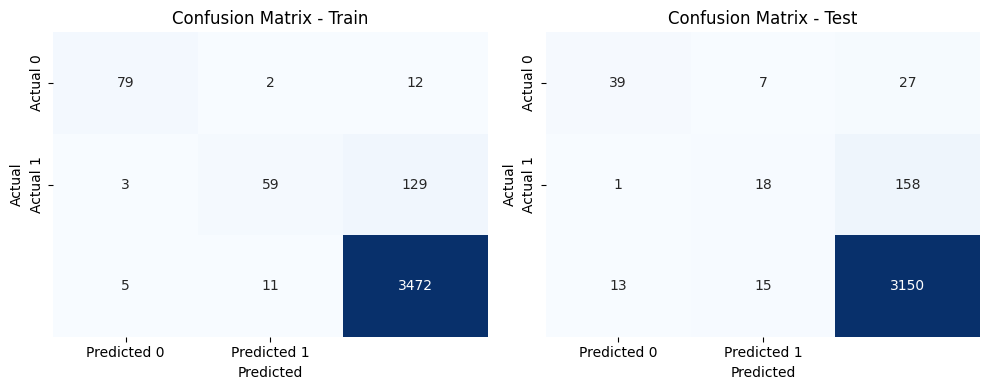


  Misclassification Rate (in %):
    Train Loss: 4.294803817603398%
    Test Loss: 6.44690781796966%
  


In [10]:
def train_and_predict_knn(X_train, y_train, X_test, y_test, n_neighbors=3):
  # Make a KNN Classifier and Train it on Dataset
  knn = KNeighborsClassifier(n_neighbors)
  knn.fit(X_train, y_train)

  # Making Predictions
  y_train_pred = knn.predict(X_train)
  y_test_pred = knn.predict(X_test)
  return knn, y_train_pred, y_test_pred

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(df_train.iloc[:, :-1], df_train.iloc[:, -1])
y_train_pred = knn.predict(df_train.iloc[:, :-1])
y_test_pred = knn.predict(df_test.iloc[:, :-1])

def evaluate_classifier(y_train, y_train_pred, y_test, y_test_pred):
  # Misclassification rate
  train_loss = 1 - accuracy_score(y_train, y_train_pred)
  test_loss = 1 - accuracy_score(y_test, y_test_pred)
  # Confusion Matrix
  train_cm = confusion_matrix(y_train, y_train_pred)
  test_cm = confusion_matrix(y_test, y_test_pred)

  plt.figure(figsize=(10, 4))
  def view_confusion_matrix(confusion_matrix, label, subplot_position):
    plt.subplot(1, 2, subplot_position)
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix - {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

  view_confusion_matrix(train_cm, 'Train', 1)
  view_confusion_matrix(test_cm, 'Test', 2)
  plt.tight_layout()
  plt.show()
  print(f"""
  {color.BLUE_BOLD}Misclassification Rate (in %):{color.END}
    Train Loss: {train_loss*100}%
    Test Loss: {test_loss*100}%
  """)

X_train, y_train = df_train.iloc[:, :-1], df_train.iloc[:, -1]
X_test, y_test = df_test.iloc[:, :-1], df_test.iloc[:, -1]
train_and_predict_knn(X_train, y_train, X_test, y_test, n_neighbors=3)
evaluate_classifier(df_train.iloc[:, -1], y_train_pred, df_test.iloc[:, -1], y_test_pred)

### Q2: Attempt to reproduce Example 4.5 from the `Lindholm et al.` textbook. You will need to:
* Convert the data into a binary classification problem.
* Train a logistic regression model on the training data.
* Evaluate the trained model to calculate a confusion matrix.
* Vary the decision threshold for the model as done in Example 4.5 and recalculate the confusion matrix.

In [18]:
# Specfic Imports
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [12]:
df_train[21] = df_train[21].map(lambda x: 0 if x == 3 else 1)
df_test[21] = df_test[21].map(lambda x: 0 if x == 3 else 1)

In [13]:
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

In [16]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)

LogisticRegression()

In [29]:
# Predict probabilities for test set
y_probs = clf.predict_proba(X_test_scaled)[:, 1]

def evaluate_multiple_thresholds(y_true, y_probs, thresholds=[0.5, 0.15]):
    results = []
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        tn, fp, fn, tp = cm.ravel()

        result_str = f"""{color.GREEN_BOLD}=== Threshold {threshold} ==={color.END}
\t{color.YELLOW_BOLD}Confusion Matrix:{color.END}
\t              Predicted
\t              0      1
\tActual  0   [{tn:^5}] [{fp:^5}]
\t        1   [{fn:^5}] [{tp:^5}]
\t
\t{color.YELLOW_BOLD}Accuracy:{color.END} {round(acc, 3)}
\t{color.YELLOW_BOLD}F1 Score:{color.END} {round(f1, 3)}
"""
        print(result_str)

evaluate_multiple_thresholds(y_test, y_probs, thresholds=[0.5, 0.15])

=== Threshold 0.5 ===
	Confusion Matrix:
	              Predicted
	              0      1
	Actual  0   [3149 ] [ 29  ]
	        1   [ 121 ] [ 129 ]
	
	Accuracy: 0.956
	F1 Score: 0.632

=== Threshold 0.15 ===
	Confusion Matrix:
	              Predicted
	              0      1
	Actual  0   [3076 ] [ 102 ]
	        1   [ 37  ] [ 213 ]
	
	Accuracy: 0.959
	F1 Score: 0.754



### Q3: In Prac W4 we applied linear regression to a pokemon dataset, where the loss function was sum of squares (or mean squared) error. Revisit this task but add
a. $L^2$; <br>
b. $L^1$ regularisation to the loss function, with some suitable value for the
regularization hyperparameter (see Section 5.3 of the textbook). <br>
Compare the coefficient values from your different trained models.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression  # Baseline
from sklearn.linear_model import Ridge, Lasso      # L^2, L^1

In [ ]:
# Load your data
df = pd.read_csv("pokemon.csv")

# Drop non-numeric or irrelevant columns (adjust this based on your dataset)
df = df.select_dtypes(include='number').dropna()

# Define features and target
X = df.drop("Total", axis=1)  # Predicting "Total" stat, for example
y = df["Total"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_coef = lr.coef_

In [ ]:
ridge = Ridge(alpha=1.0)  # Regularization strength (adjustable)
ridge.fit(X_train_scaled, y_train)
ridge_coef = ridge.coef_

In [ ]:
lasso = Lasso(alpha=0.1)  # Regularization strength (adjustable)
lasso.fit(X_train_scaled, y_train)
lasso_coef = lasso.coef_

In [ ]:
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Linear": lr_coef,
    "Ridge": ridge_coef,
    "Lasso": lasso_coef
})
print(coef_df)

### References:
* https://www.askpython.com/python/examples/read-data-files-in-python